In [111]:
import os
import glob

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler

In [112]:
def load_clean_csv(path):
    with open(path, 'r', encoding='utf-8-sig') as f:
        lines = f.readlines()

    header_idx = None
    for i, line in enumerate(lines):
        if "날짜 시간" in line:
            header_idx = i
            break

    if header_idx is None:
        raise ValueError(f"'날짜 시간' 행을 찾을 수 없습니다: {path}")

    df = pd.read_csv(path, skiprows=header_idx)
    df['날짜 시간'] = pd.to_datetime(df['날짜 시간'])
    df['날짜'] = df['날짜 시간'].dt.date

    # ---- 클로로필 관련 열 자동 탐색 ----
    chl_cols = [c for c in df.columns if "Chlorophyll" in c and "농도" in c]

    for col in chl_cols:
        if "(ppb)" in col:
            # ppb → µg/L 변환
            df[col.replace("(ppb)", "(µg/L)")] = df[col]
            df.drop(columns=[col], inplace=True)
            
    return df

In [113]:
def summarize_point_folder(point_folder, save_dir):
    """하나의 포인트 폴더 내 모든 날짜 CSV를 불러와 평균 요약"""
    summary_list = []

    for date_folder in sorted(os.listdir(point_folder)):
        date_path = os.path.join(point_folder, date_folder)
        if not os.path.isdir(date_path):
            continue  # 혹시 폴더 아닌게 섞여 있을 수도 있음

        daily_dfs = []

        for file in os.listdir(date_path):
            if not file.endswith(".csv"):
                continue
            file_path = os.path.join(date_path, file)
            try:
                df = load_clean_csv(file_path)
                daily_dfs.append(df)
            except Exception as e:
                print(f"⚠️ {file_path} 로드 실패: {e}")

        if len(daily_dfs) == 0:
            continue

        # 여러 CSV를 concat 후 평균 계산
        daily_df = pd.concat(daily_dfs)
        daily_mean = daily_df.mean(numeric_only=True)
        daily_mean["날짜"] = pd.to_datetime(date_folder, format="%Y%m%d").date()

        summary_list.append(daily_mean)

    # 날짜별 평균이 담긴 DataFrame 생성
    if len(summary_list) > 0:
        summary_df = pd.DataFrame(summary_list)
        summary_df.sort_values("날짜", inplace=True)
        cols = ["날짜"] + [c for c in summary_df.columns if c != "날짜"]
        summary_df = summary_df[cols]
        
        point_name = os.path.basename(point_folder.rstrip("/\\"))
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f"{point_name}_summary.csv")
        summary_df.to_csv(save_path, index=False, encoding='utf-8-sig')
        print(f"✅ {point_name} 요약 CSV 저장 완료 → {save_path}")
    else:
        print(f"❌ {point_folder} 요약 데이터 없음.")


In [114]:
data_dir = "point_data"
dataset = glob.glob(os.path.join(data_dir, "**", "*.csv"), recursive=True)
print(len(dataset))
print(dataset[0])

490
point_data\포인트1\20250402\VuSitu_라이브_리딩_2025-04-02_11-07-40_장치_위치.csv


In [115]:
sample_path = dataset[0]
df = load_clean_csv(sample_path)

print("파일 경로:", sample_path)
print("데이터 shape:", df.shape)
print("컬럼명:", df.columns.tolist())
# print(df.head())

파일 경로: point_data\포인트1\20250402\VuSitu_라이브_리딩_2025-04-02_11-07-40_장치_위치.csv
데이터 shape: (69, 26)
컬럼명: ['날짜 시간', 'Actual Conductivity (µS/cm) (1066342)', 'Specific Conductivity (µS/cm) (1066342)', '염도 (PSU) (1066342)', '저항력 (Ω⋅cm) (1066342)', '밀도 (g/cm³) (1066342)', '총 용존 고형물 (TDS) (ppt) (1066342)', 'pH (pH) (1057024)', 'pH mV (mV) (1057024)', 'ORP (mV) (1057024)', '온도 (°C) (1068851)', '압력 (psi) (1064654)', '깊이 (m) (1064654)', '표면 고도 (m) (1064654)', 'RDO 농도 (mg/L) (954526)', 'RDO 포화 (%Sat) (954526)', '산소분압 (Torr) (954526)', 'Chlorophyll-a Fluorescence (RFU) (945787)', 'Chlorophyll-a 농도 (µg/L) (945787)', '외부 전압 (V) (1068851)', '대기압 (mbar) (1049665)', '온도 (°C) (1049665)', '위도 (°)', '경도 (°)', '표시됨', '날짜']


In [116]:
data_num = len(dataset)
train_dataset, val_dataset, test_dataset = dataset[:int(data_num*0.8)], dataset[int(data_num*0.8):int(data_num*0.9)], dataset[int(data_num*0.9):]
print(len(train_dataset), len(val_dataset), len(test_dataset))

392 49 49


In [117]:
# def make_sequences(df_point, input_days=7):
#     X, y = [], []
#     for i in range(len(df_point) - input_days):
#         X.append(df_point.iloc[i:i+input_days].values)
#         y.append(df_point.iloc[i+input_days]["chlorophyll"])  # 다음날 예측
#     return np.array(X), np.array(y)

In [118]:
class VanillaLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        """
        input_size: 입력 feature 수
        hidden_size: LSTM hidden 차원
        num_layers: LSTM 층 수
        output_size: 예측값 차원
        """
        super(VanillaLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        x: [batch_size, seq_len, input_size]
        """
        out, _ = self.lstm(x)       # out: [batch, seq_len, hidden_size]
        out = out[:, -1, :]          # 마지막 시점 출력
        out = self.fc(out)           # [batch, output_size]
        return out

In [119]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [120]:
dataset_root = "point_data"      # 포인트 폴더들이 들어 있는 상위 폴더
output_dir = "summaries"      # 요약본 저장 폴더
os.makedirs(output_dir, exist_ok=True)

for point_folder in sorted(os.listdir(dataset_root)):
    full_path = os.path.join(dataset_root, point_folder)
    if os.path.isdir(full_path):
        summarize_point_folder(full_path, output_dir)

✅ 포인트1 요약 CSV 저장 완료 → summaries\포인트1_summary.csv
✅ 포인트2 요약 CSV 저장 완료 → summaries\포인트2_summary.csv
✅ 포인트3 요약 CSV 저장 완료 → summaries\포인트3_summary.csv
✅ 포인트4 요약 CSV 저장 완료 → summaries\포인트4_summary.csv
✅ 포인트5 요약 CSV 저장 완료 → summaries\포인트5_summary.csv


In [121]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("summaries/포인트1_summary.csv")

# 날짜 제거 (index로 쓰거나 feature에서 제외)
df['날짜'] = pd.to_datetime(df['날짜'])
df = df.sort_values('날짜')
features = df.drop(columns=['날짜', '표시됨']).values
print("Features shape:", features.shape)

# 정규화 (LSTM은 scale 민감)
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

seq_len = 7
X, y = [], []
for i in range(len(features) - seq_len):
    X.append(features[i:i+seq_len])    # 7일 입력
    y.append(features[i+seq_len])      # 다음날 출력
X = np.array(X)
y = np.array(y)
dataset = TimeSeriesDataset(X, y)
print(f"X shape: {X.shape}, y shape: {y.shape}")
print(len(dataset), "samples in dataset")

n_total = len(dataset)
n_train = int(n_total * 0.8)
n_val = int(n_total * 0.1)
n_test = n_total - n_train - n_val

train_set, val_set, test_set = random_split(dataset, [n_train, n_val, n_test])
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=8)
test_loader = DataLoader(test_set, batch_size=8)

input_size = X.shape[2]
hidden_size = 64
num_layers = 2
output_size = y.shape[1]
model = VanillaLSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Features shape: (31, 23)
X shape: (24, 7, 23), y shape: (24, 23)
24 samples in dataset


In [122]:
print("🔍 NaN 개수:", np.isnan(features).sum())
print("🔍 inf 개수:", np.isinf(features).sum())
print("🔍 각 컬럼별 최소/최대:")
print(pd.DataFrame(features).agg(['min', 'max']).T.head())

🔍 NaN 개수: 0
🔍 inf 개수: 0
🔍 각 컬럼별 최소/최대:
   min  max
0  0.0  1.0
1  0.0  1.0
2  0.0  1.0
3  0.0  1.0
4  0.0  1.0


In [123]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # 검증
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            preds = model(X_val)
            val_loss += criterion(preds, y_val).item()

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {total_loss/len(train_loader):.6f} | Val Loss: {val_loss/len(val_loader):.6f}")


Epoch [1/100] Train Loss: 0.297517 | Val Loss: 0.290937
Epoch [2/100] Train Loss: 0.269970 | Val Loss: 0.267883
Epoch [3/100] Train Loss: 0.245167 | Val Loss: 0.237121
Epoch [4/100] Train Loss: 0.222990 | Val Loss: 0.194398
Epoch [5/100] Train Loss: 0.168360 | Val Loss: 0.142517
Epoch [6/100] Train Loss: 0.107586 | Val Loss: 0.112828
Epoch [7/100] Train Loss: 0.078701 | Val Loss: 0.136103
Epoch [8/100] Train Loss: 0.078421 | Val Loss: 0.143539
Epoch [9/100] Train Loss: 0.074571 | Val Loss: 0.132265
Epoch [10/100] Train Loss: 0.055430 | Val Loss: 0.124070
Epoch [11/100] Train Loss: 0.065806 | Val Loss: 0.124746
Epoch [12/100] Train Loss: 0.064849 | Val Loss: 0.120975
Epoch [13/100] Train Loss: 0.062420 | Val Loss: 0.116560
Epoch [14/100] Train Loss: 0.060093 | Val Loss: 0.115579
Epoch [15/100] Train Loss: 0.055698 | Val Loss: 0.118456
Epoch [16/100] Train Loss: 0.055281 | Val Loss: 0.120062
Epoch [17/100] Train Loss: 0.053885 | Val Loss: 0.122387
Epoch [18/100] Train Loss: 0.060165 | Va

In [124]:
model.eval()
test_loss = 0
with torch.no_grad():
    for X_test, y_test in test_loader:
        preds = model(X_test)
        test_loss += criterion(preds, y_test).item()
print(f"\n✅ Test Loss: {test_loss/len(test_loader):.6f}")


✅ Test Loss: 0.021784


C:\Users\ty\AppData\Local\Temp\ipykernel_4472\3124369121.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
C:\Users\ty\AppData\Local\Temp\ipykernel_4472\3124369121.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


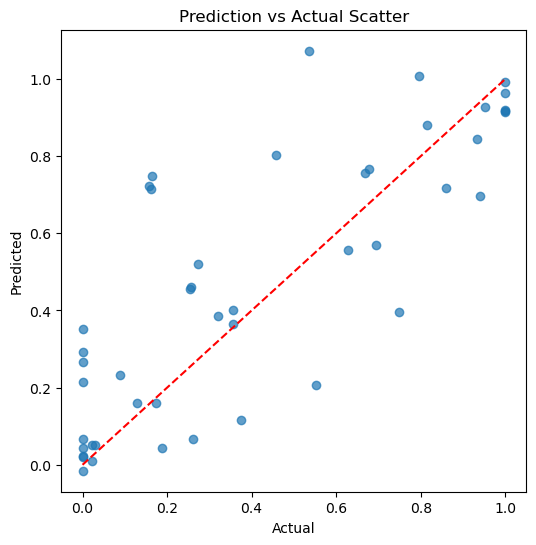

Validation RMSE: 0.2307


In [129]:
model.eval()

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

with torch.no_grad():
    y_pred = model(X_val_tensor).squeeze().numpy()  # 예측값

# 실제 값
y_true = y_val_tensor.numpy()

# 2. 산점도로 비교 (예측 vs 실제)
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.7)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # y=x 기준선
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Prediction vs Actual Scatter")
plt.show()

# 3. RMSE 계산
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Validation RMSE: {rmse:.4f}")

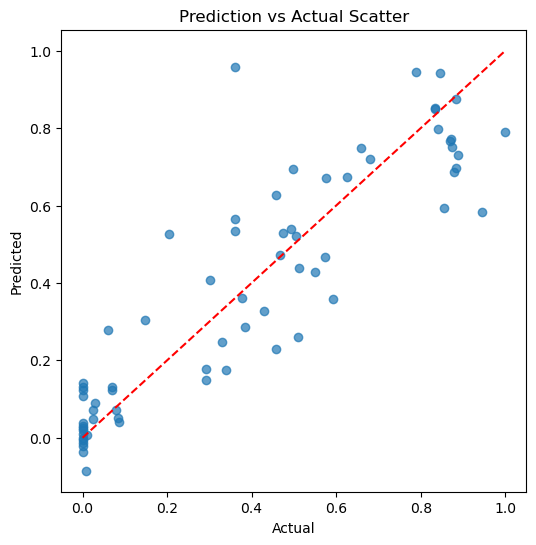

Test MSE: 0.0218, RMSE: 0.1476


In [128]:
model.eval()  # 평가 모드로 전환
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.float()
        y_batch = y_batch.float()

        y_pred = model(X_batch)
        all_preds.append(y_pred.cpu())
        all_labels.append(y_batch.cpu())

# 결과 합치기
y_pred = torch.cat(all_preds, dim=0).numpy()
y_true = torch.cat(all_labels, dim=0).numpy()

# 예측 vs 실제 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.7)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # y=x 기준선
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Prediction vs Actual Scatter")
plt.show()

# 성능 지표 예: MSE, RMSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_true, y_pred)
rmse = mse ** 0.5
print(f"Test MSE: {mse:.4f}, RMSE: {rmse:.4f}")
